In [1]:
import pandas as pd
import numpy as np
import gensim, logging
# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec

# Problem 1

Download word2vec application from https://github.com/dav/word2vec. Compile the application following description in the lecture notes. Modify demo_word.sh so that you could generate 300-dimensional vector representations of words in text8 file. Please note that you must have gcc compiler installed. You also need to have wget application installed. Your file demo-word.sh has a switch (flag) called binary. If you set -binary 1, you will generate a binary file for your embedded vectors. Flag -binary 0 should generates a text file. Use text option so that you could easily examine generated embedded vectors. Import generated text file into a panda and display top 5 rows, using pandas.head(). At the end of the demo-word.sh script you can use executable distance to ask for the closest words to a provided word. Use a word of your choice. Provide us with the first 10 results.

In [2]:
#read vectors.txt and display first 5 rows
df = pd.read_fwf("/Users/Matt/CS89/word2vec-master2/vectors.txt")
df.head(5)

,71291 100
0,</s> 0.004003 0.004419 -0.003830 -0.003278 0.0...
1,the -1.201609 0.660647 0.954404 -0.793924 -1.6...
2,of -0.789573 0.388450 1.554972 0.210264 -1.688...
3,and -1.277516 0.836913 0.278921 0.811357 -0.03...
4,one -1.190647 0.758546 -1.666799 -0.582802 -0....


### demo-word output for 'justice'

Word: justice  Position in vocabulary: 1294

                                              Word       Cosine distance
------------------------------------------------------------------------
                                           supreme		0.624204
                                         rehnquist		0.567805
                                             judge		0.553716
                                            scalia		0.538168
                                           counsel		0.529830
                                             court		0.519830
                                           affairs		0.515010
                                            puisne		0.514206
                                              voir		0.512786
                                          tribunal		0.511065

# Problem 2

Examine examples of analogic reasoning using Gensim API we mentioned in Lecture 09 and demonstrated in the attached Lab. Use GoogleNews 300 dimensional embedded vectors. One such example is “what is to Russia, what Paris is to France?” Resulting pairs of words should be: russia - moscow, and france – paris. Use three more similar country-capital analogies and present them in the same PCA plane. Please note that you have to learn how to use a PCA (Principle Component Analsis) code from Scikit-learn or some other framework. In your diagram, according to Word2Vec marketing department, country-capital words should be connected by close to parallel lines. We are just curious whether that is true and are all lines closely parallel. Please add a graphical line connecting every country with the respective capital.  Subsequently, examine another set of analogies, different than country-capital. Repeat the “analogic reasoning” analysis using the script demo-analogy.sh with Word2Vec embedded vectors. Results of analogy reasoning can be different when using two different sets of embedded vectors.

In [205]:
#define logging level to only show warnings
logging.basicConfig(format='%(asctime)s: %levelname)s: %(message)s',level= logging.WARNING)

In [154]:
#load gensim word2vec model from local copy of google news vectors
gnewsfile = datapath('/Users/Matt/CS89/GoogleNews-vectors-negative300.bin')
model = gensim.models.KeyedVectors.load_word2vec_format(gnewsfile, binary=True) 

In [155]:
# Get word similarity using out of the box task
most_similar = model.most_similar(positive=['emperor', 'woman'], negative=['man'])
print(most_similar)

[('empress', 0.6470329165458679), ('emperors', 0.6074110865592957), ('Emperor', 0.5940502285957336), ('empresses', 0.5697327256202698), ('Wu_Zetian', 0.5530362129211426), ('imperial_throne', 0.5474318265914917), ('Empress_Dowager_Cixi', 0.5443989634513855), ('Queen_Consort', 0.5418635606765747), ('imperial', 0.5319660902023315), ('Imperial_Household', 0.528858482837677)]


In [156]:
#define function for analogic reasoning
def analogy(x1, x2, y1):
	result = model.most_similar(positive=[y1, x2], negative=[x1])
	return result[0][0]

In [157]:
analogy('switzerland', 'geneva', 'germany')

'german'

In [158]:
analogy('greece','athens','britain')

'nyc'

In [121]:
#define display_pca_scatterplot updated for gensim 4
def display_pca_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(model.index_to_key, sample)
        else:
            words = model.index_to_key
    
    word_vectors = np.array([model[word] for word in words])
    twodim = PCA().fit_transform(word_vectors)[:, :2]
    
    plt.figure(figsize=(6, 6))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)

    plt.show()

<IPython.core.display.Javascript object>


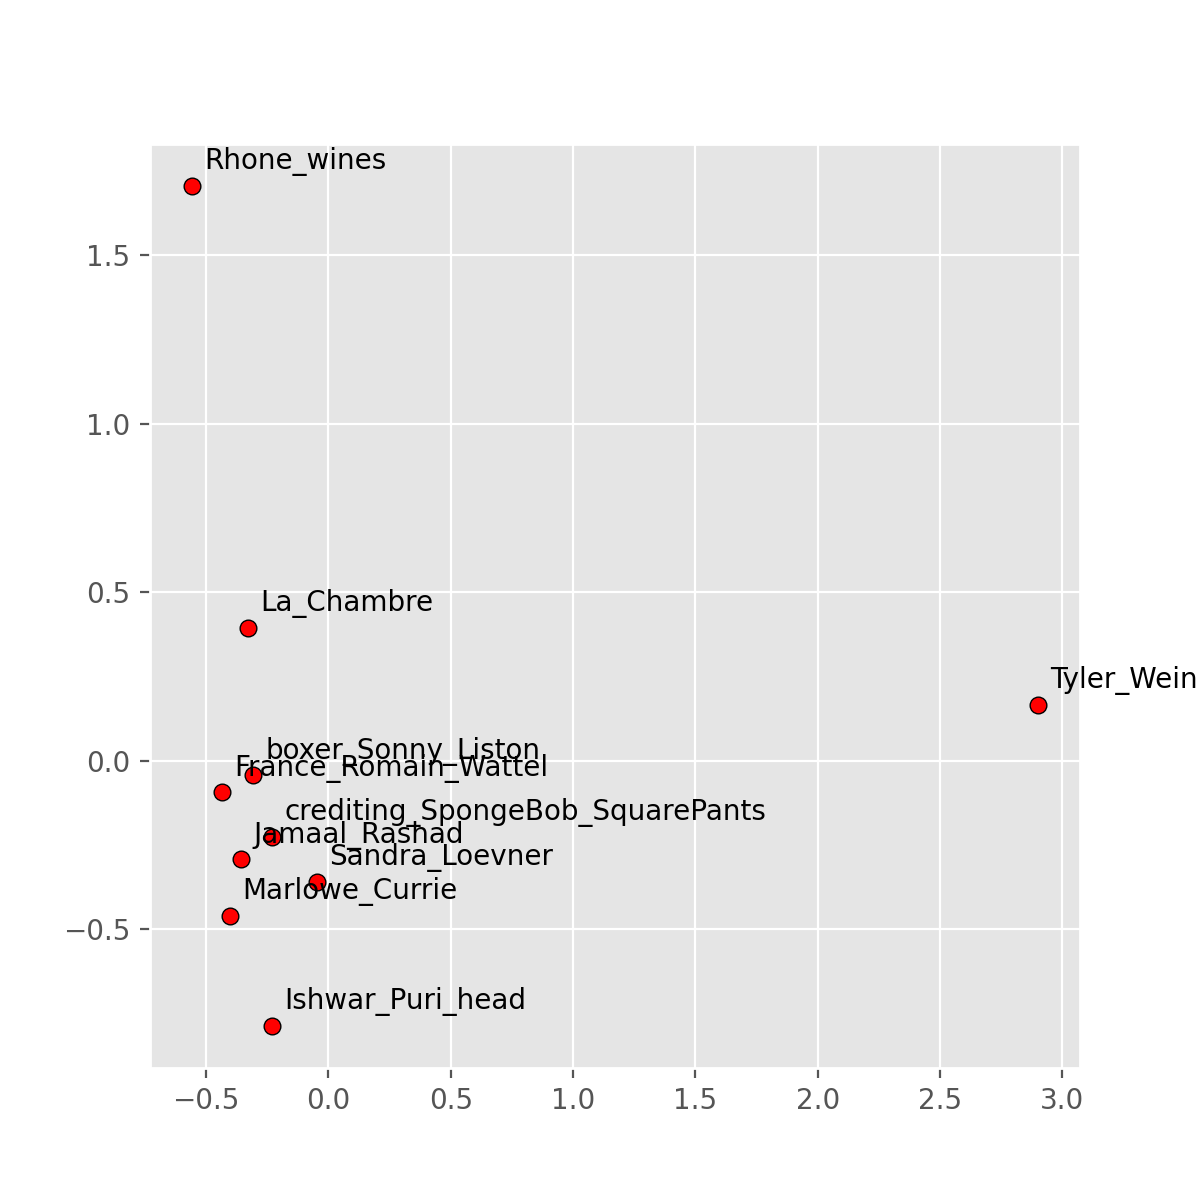

In [160]:
#explore random sample of pca scatterplot
display_pca_scatterplot(model, sample=10)

In [161]:
#explore analogies
analogy('france', 'paris', 'russia')

'north_korea'

In [162]:
analogy('madrid','spain','rome')

'venice'

In [169]:
#create list of countries-capitals to plot in PCA plane
countries = ["russia", "norway", "finland", "japan", "germany", "france", "italy", "greece"]
capitals  = ["moscow", "oslo", "helsinki", "tokyo",  "berlin",  "paris",  "rome",  "athens"]

In [175]:
#define a function to plot country-capital pairs connected by lines

def plot_pairs(wv, a, b):
    ndx_a = [wv.key_to_index[a_i] for a_i in a if a_i in wv.key_to_index and a_i in wv]
    ndx_b = [wv.key_to_index[b_i] for b_i in b if b_i in wv.key_to_index and b_i in wv]

    if not ndx_a or not ndx_b:
        print("Error: No valid indices for PCA. Check your input words.")
        invalid_words_a = [a_i for a_i in a if a_i not in wv.key_to_index or a_i not in wv]
        invalid_words_b = [b_i for b_i in b if b_i not in wv.key_to_index or b_i not in wv]
        print("Invalid words in 'countries':", invalid_words_a)
        print("Invalid words in 'capitals':", invalid_words_b)
        return

    vectors_a = wv.vectors[ndx_a]
    vectors_b = wv.vectors[ndx_b]

    pca = PCA(2)
    wv2 = pca.fit_transform(np.vstack([vectors_a, vectors_b]))

    wv_a = wv2[:len(ndx_a)]
    wv_b = wv2[len(ndx_b):]

    plt.figure(figsize=(10, 10))
    plt.scatter(wv_a[:, 0], wv_a[:, 1], label='Countries')
    plt.scatter(wv_b[:, 0], wv_b[:, 1], label='Capitals')

    for i, (p_a, p_b) in enumerate(zip(a, b)):
        plt.annotate(p_a, wv_a[i], xytext=(-20, -15), textcoords="offset pixels")
        plt.annotate(p_b, wv_b[i], xytext=(10, 10), textcoords="offset pixels")

    for i in range(len(wv_a)):
        plt.arrow(wv_a[i, 0], wv_a[i, 1], wv_b[i, 0] - wv_a[i, 0], wv_b[i, 1] - wv_a[i, 1], shape="left", color="black")

    plt.legend()
    plt.show()


<IPython.core.display.Javascript object>


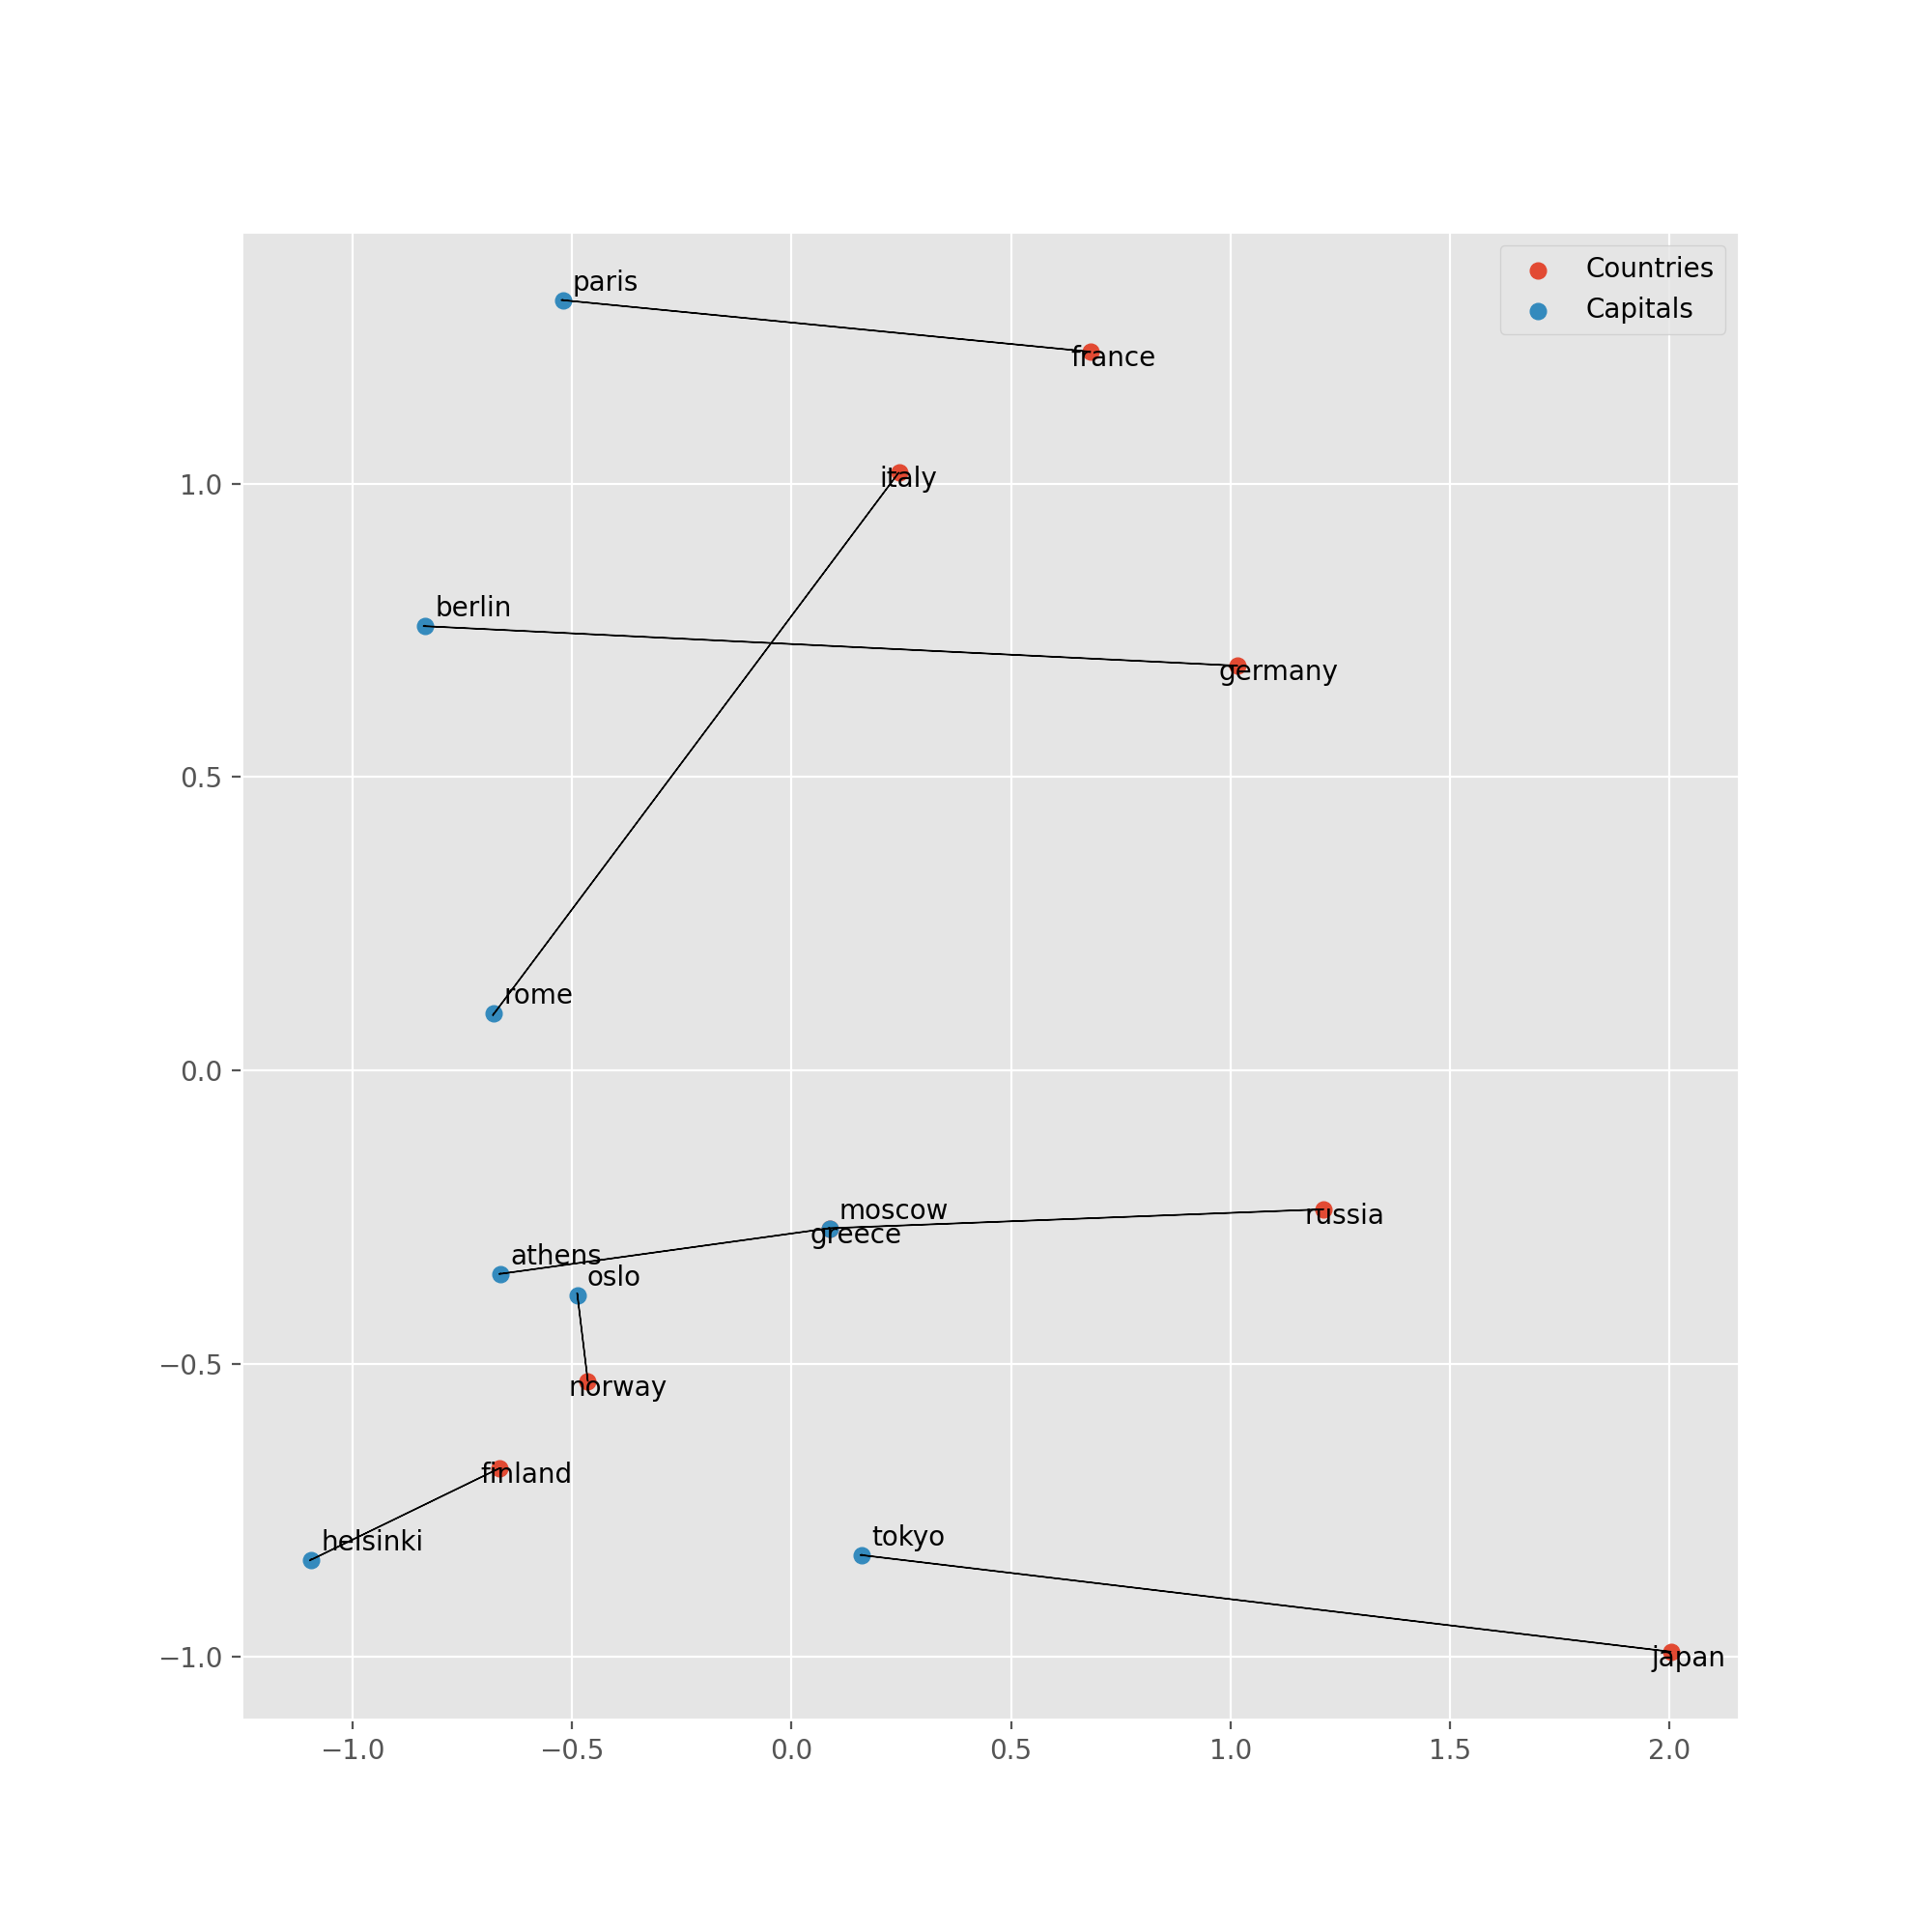

In [176]:
#plot country capital pairs
plot_pairs(model, countries, capitals)

As we see above, we observe clusters of several country-capital pairs that are roughly parallel, however notably the oslo-norway is not parallel to others in its cluster as it intersects with them, similarly with the italy-rome.   

In [128]:
animal = ['cow', 'pig', 'sheep', 'deer']
food = ['beef', 'pork', 'lamb', 'venison']

In [177]:
def plot_pairs(wv, a, b):
    ndx_a = [wv.key_to_index[a_i] for a_i in a if a_i in wv.key_to_index and a_i in wv]
    ndx_b = [wv.key_to_index[b_i] for b_i in b if b_i in wv.key_to_index and b_i in wv]

    if not ndx_a or not ndx_b:
        print("Error: No valid indices for PCA. Check your input words.")
        invalid_words_a = [a_i for a_i in a if a_i not in wv.key_to_index or a_i not in wv]
        invalid_words_b = [b_i for b_i in b if b_i not in wv.key_to_index or b_i not in wv]
        print("Invalid words in 'animals':", invalid_words_a)
        print("Invalid words in 'food':", invalid_words_b)
        return

    vectors_a = wv.vectors[ndx_a]
    vectors_b = wv.vectors[ndx_b]

    pca = PCA(2)
    wv2 = pca.fit_transform(np.vstack([vectors_a, vectors_b]))

    wv_a = wv2[:len(ndx_a)]
    wv_b = wv2[len(ndx_b):]

    plt.figure(figsize=(10, 10))
    plt.scatter(wv_a[:, 0], wv_a[:, 1], label='Animal')
    plt.scatter(wv_b[:, 0], wv_b[:, 1], label='Food')

    for i, (p_a, p_b) in enumerate(zip(a, b)):
        plt.annotate(p_a, wv_a[i], xytext=(-20, -15), textcoords="offset pixels")
        plt.annotate(p_b, wv_b[i], xytext=(10, 10), textcoords="offset pixels")

    for i in range(len(wv_a)):
        plt.arrow(wv_a[i, 0], wv_a[i, 1], wv_b[i, 0] - wv_a[i, 0], wv_b[i, 1] - wv_a[i, 1], shape="left", color="black")

    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


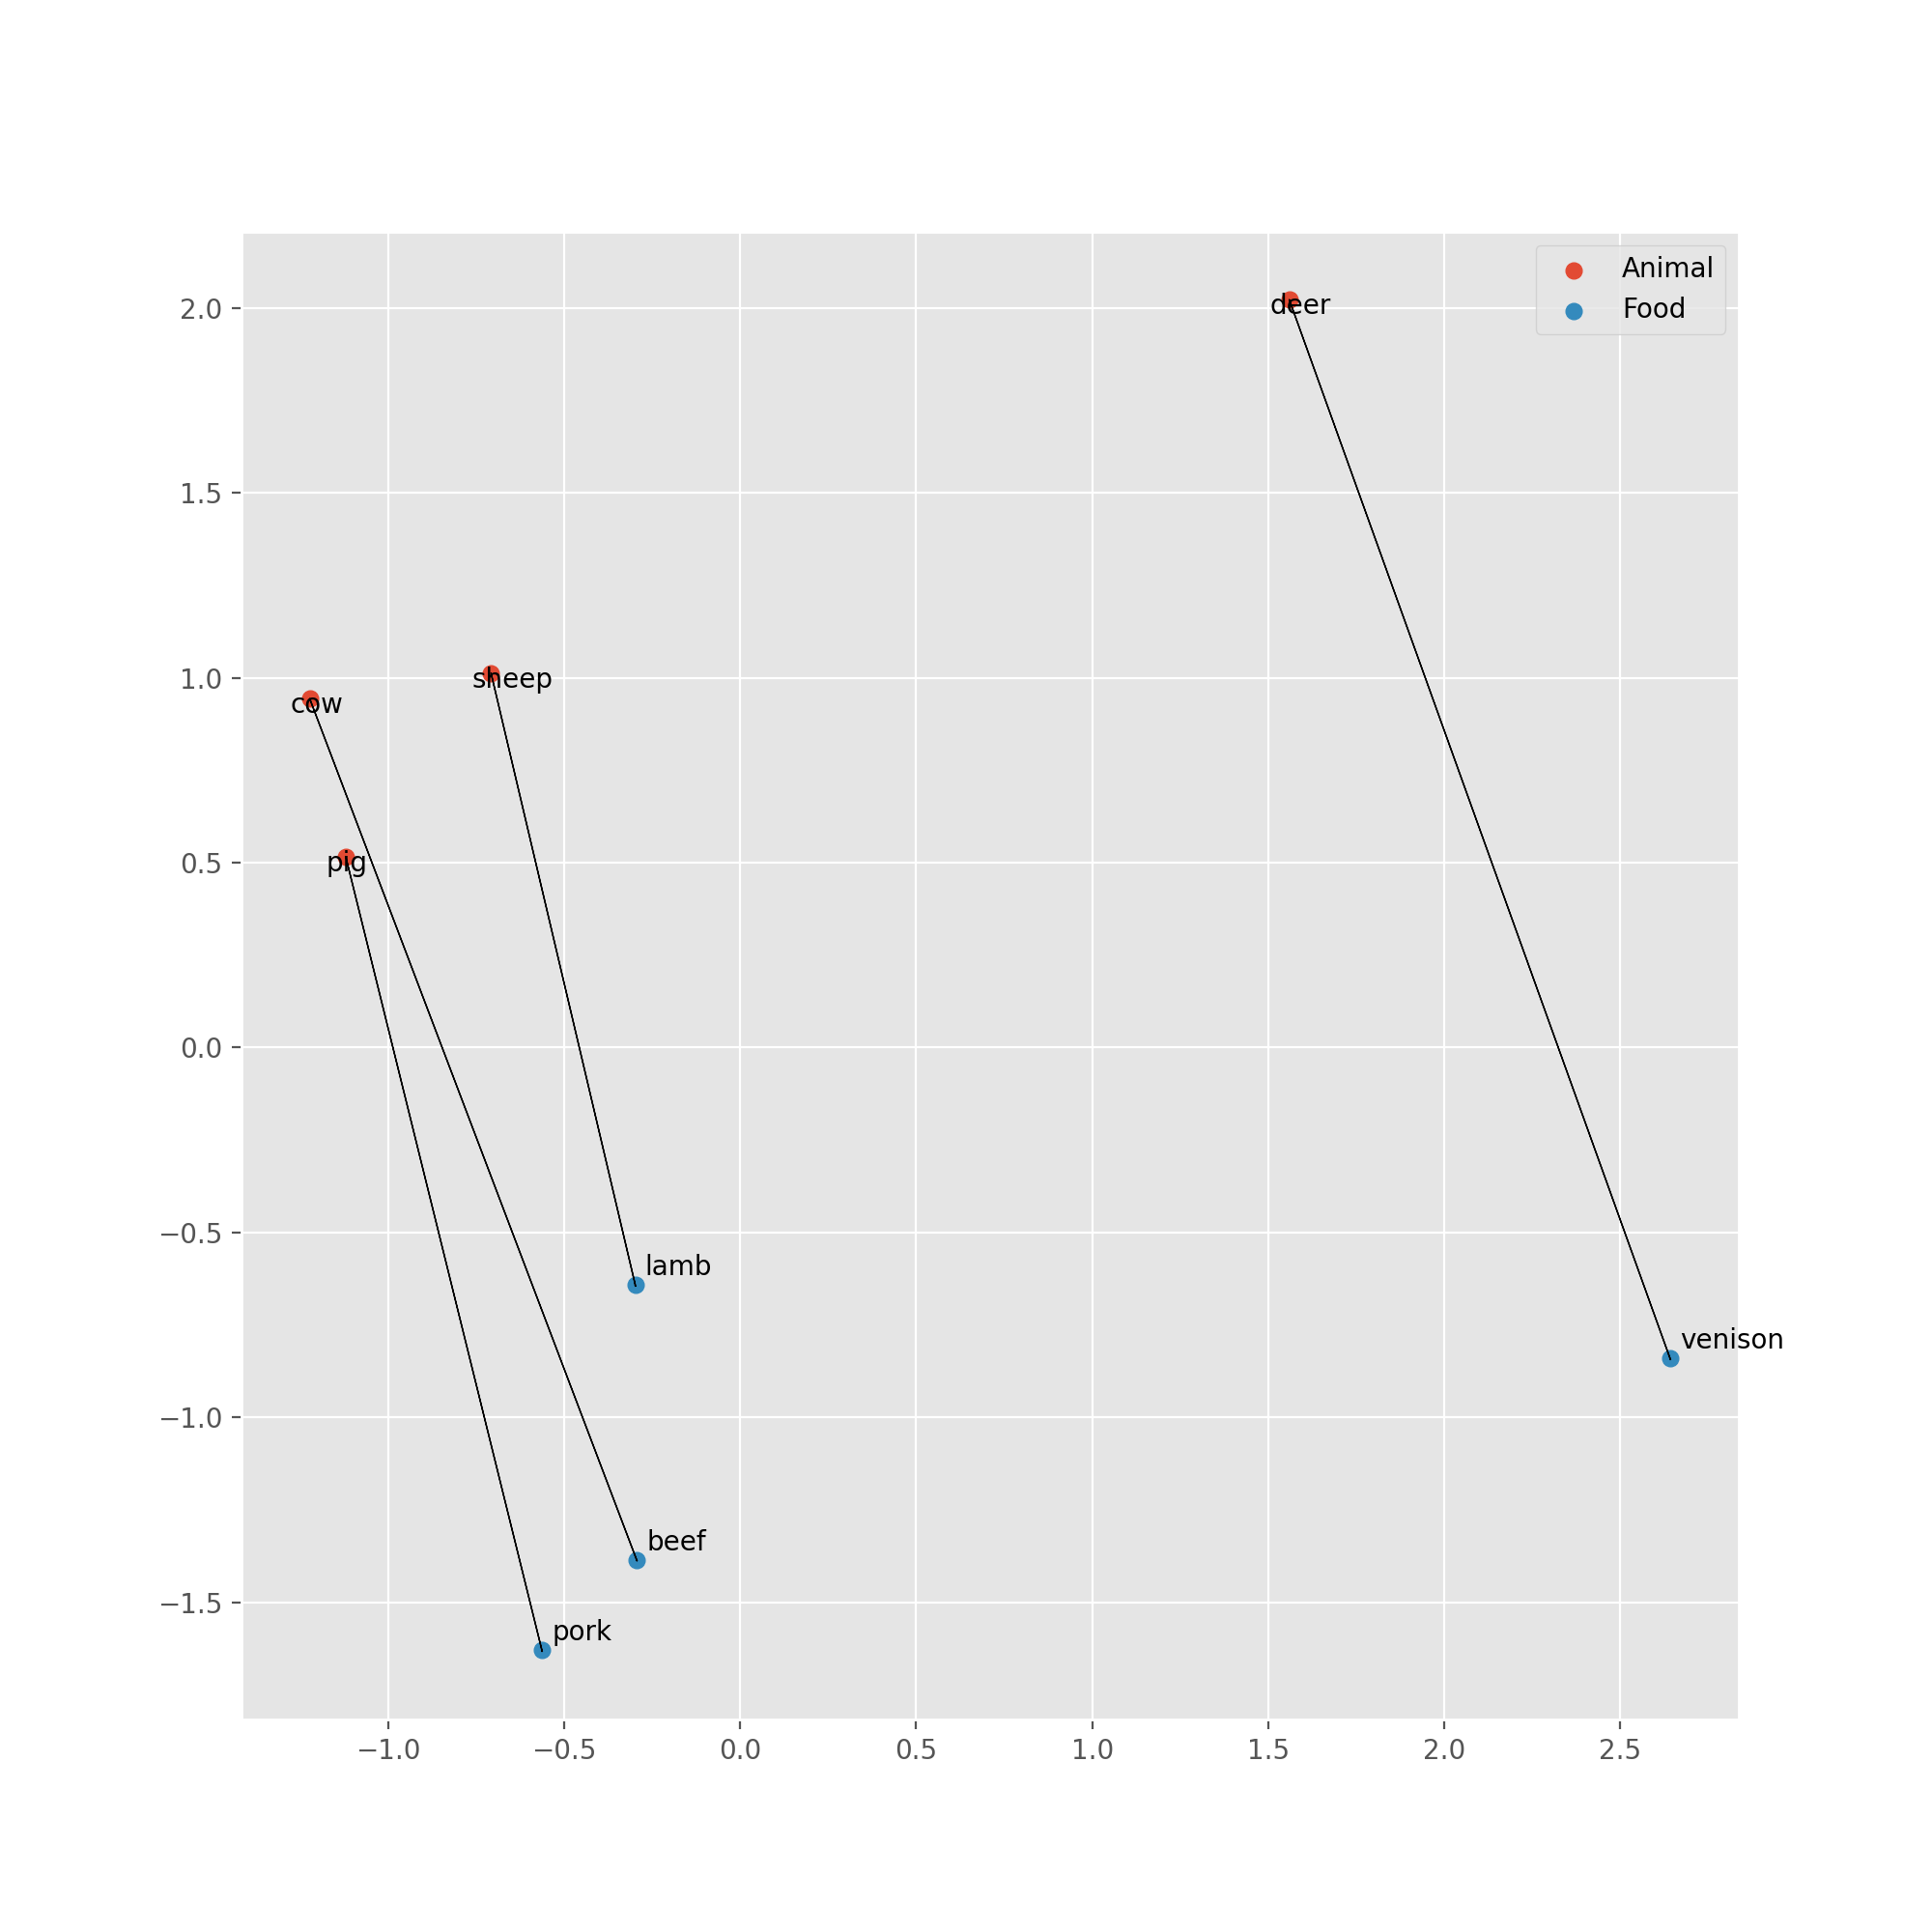

In [178]:
#plot animal food pairs
plot_pairs(model, animal, food)

We observe highly parallelized pairs of animals and meat

In [201]:
tools = ['hammer', 'drill' , 'saw']
objects = ['nail', 'hole', 'wood']

In [202]:
def plot_pairs(wv, a, b):
    ndx_a = [wv.key_to_index[a_i] for a_i in a if a_i in wv.key_to_index and a_i in wv]
    ndx_b = [wv.key_to_index[b_i] for b_i in b if b_i in wv.key_to_index and b_i in wv]

    if not ndx_a or not ndx_b:
        print("Error: No valid indices for PCA. Check your input words.")
        invalid_words_a = [a_i for a_i in a if a_i not in wv.key_to_index or a_i not in wv]
        invalid_words_b = [b_i for b_i in b if b_i not in wv.key_to_index or b_i not in wv]
        print("Invalid words in 'countries':", invalid_words_a)
        print("Invalid words in 'capitals':", invalid_words_b)
        return

    vectors_a = wv.vectors[ndx_a]
    vectors_b = wv.vectors[ndx_b]

    pca = PCA(2)
    wv2 = pca.fit_transform(np.vstack([vectors_a, vectors_b]))

    wv_a = wv2[:len(ndx_a)]
    wv_b = wv2[len(ndx_b):]

    plt.figure(figsize=(10, 10))
    plt.scatter(wv_a[:, 0], wv_a[:, 1], label='Tools')
    plt.scatter(wv_b[:, 0], wv_b[:, 1], label='Objects')

    for i, (p_a, p_b) in enumerate(zip(a, b)):
        plt.annotate(p_a, wv_a[i], xytext=(-20, -15), textcoords="offset pixels")
        plt.annotate(p_b, wv_b[i], xytext=(10, 10), textcoords="offset pixels")

    for i in range(len(wv_a)):
        plt.arrow(wv_a[i, 0], wv_a[i, 1], wv_b[i, 0] - wv_a[i, 0], wv_b[i, 1] - wv_a[i, 1], shape="left", color="black")

    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


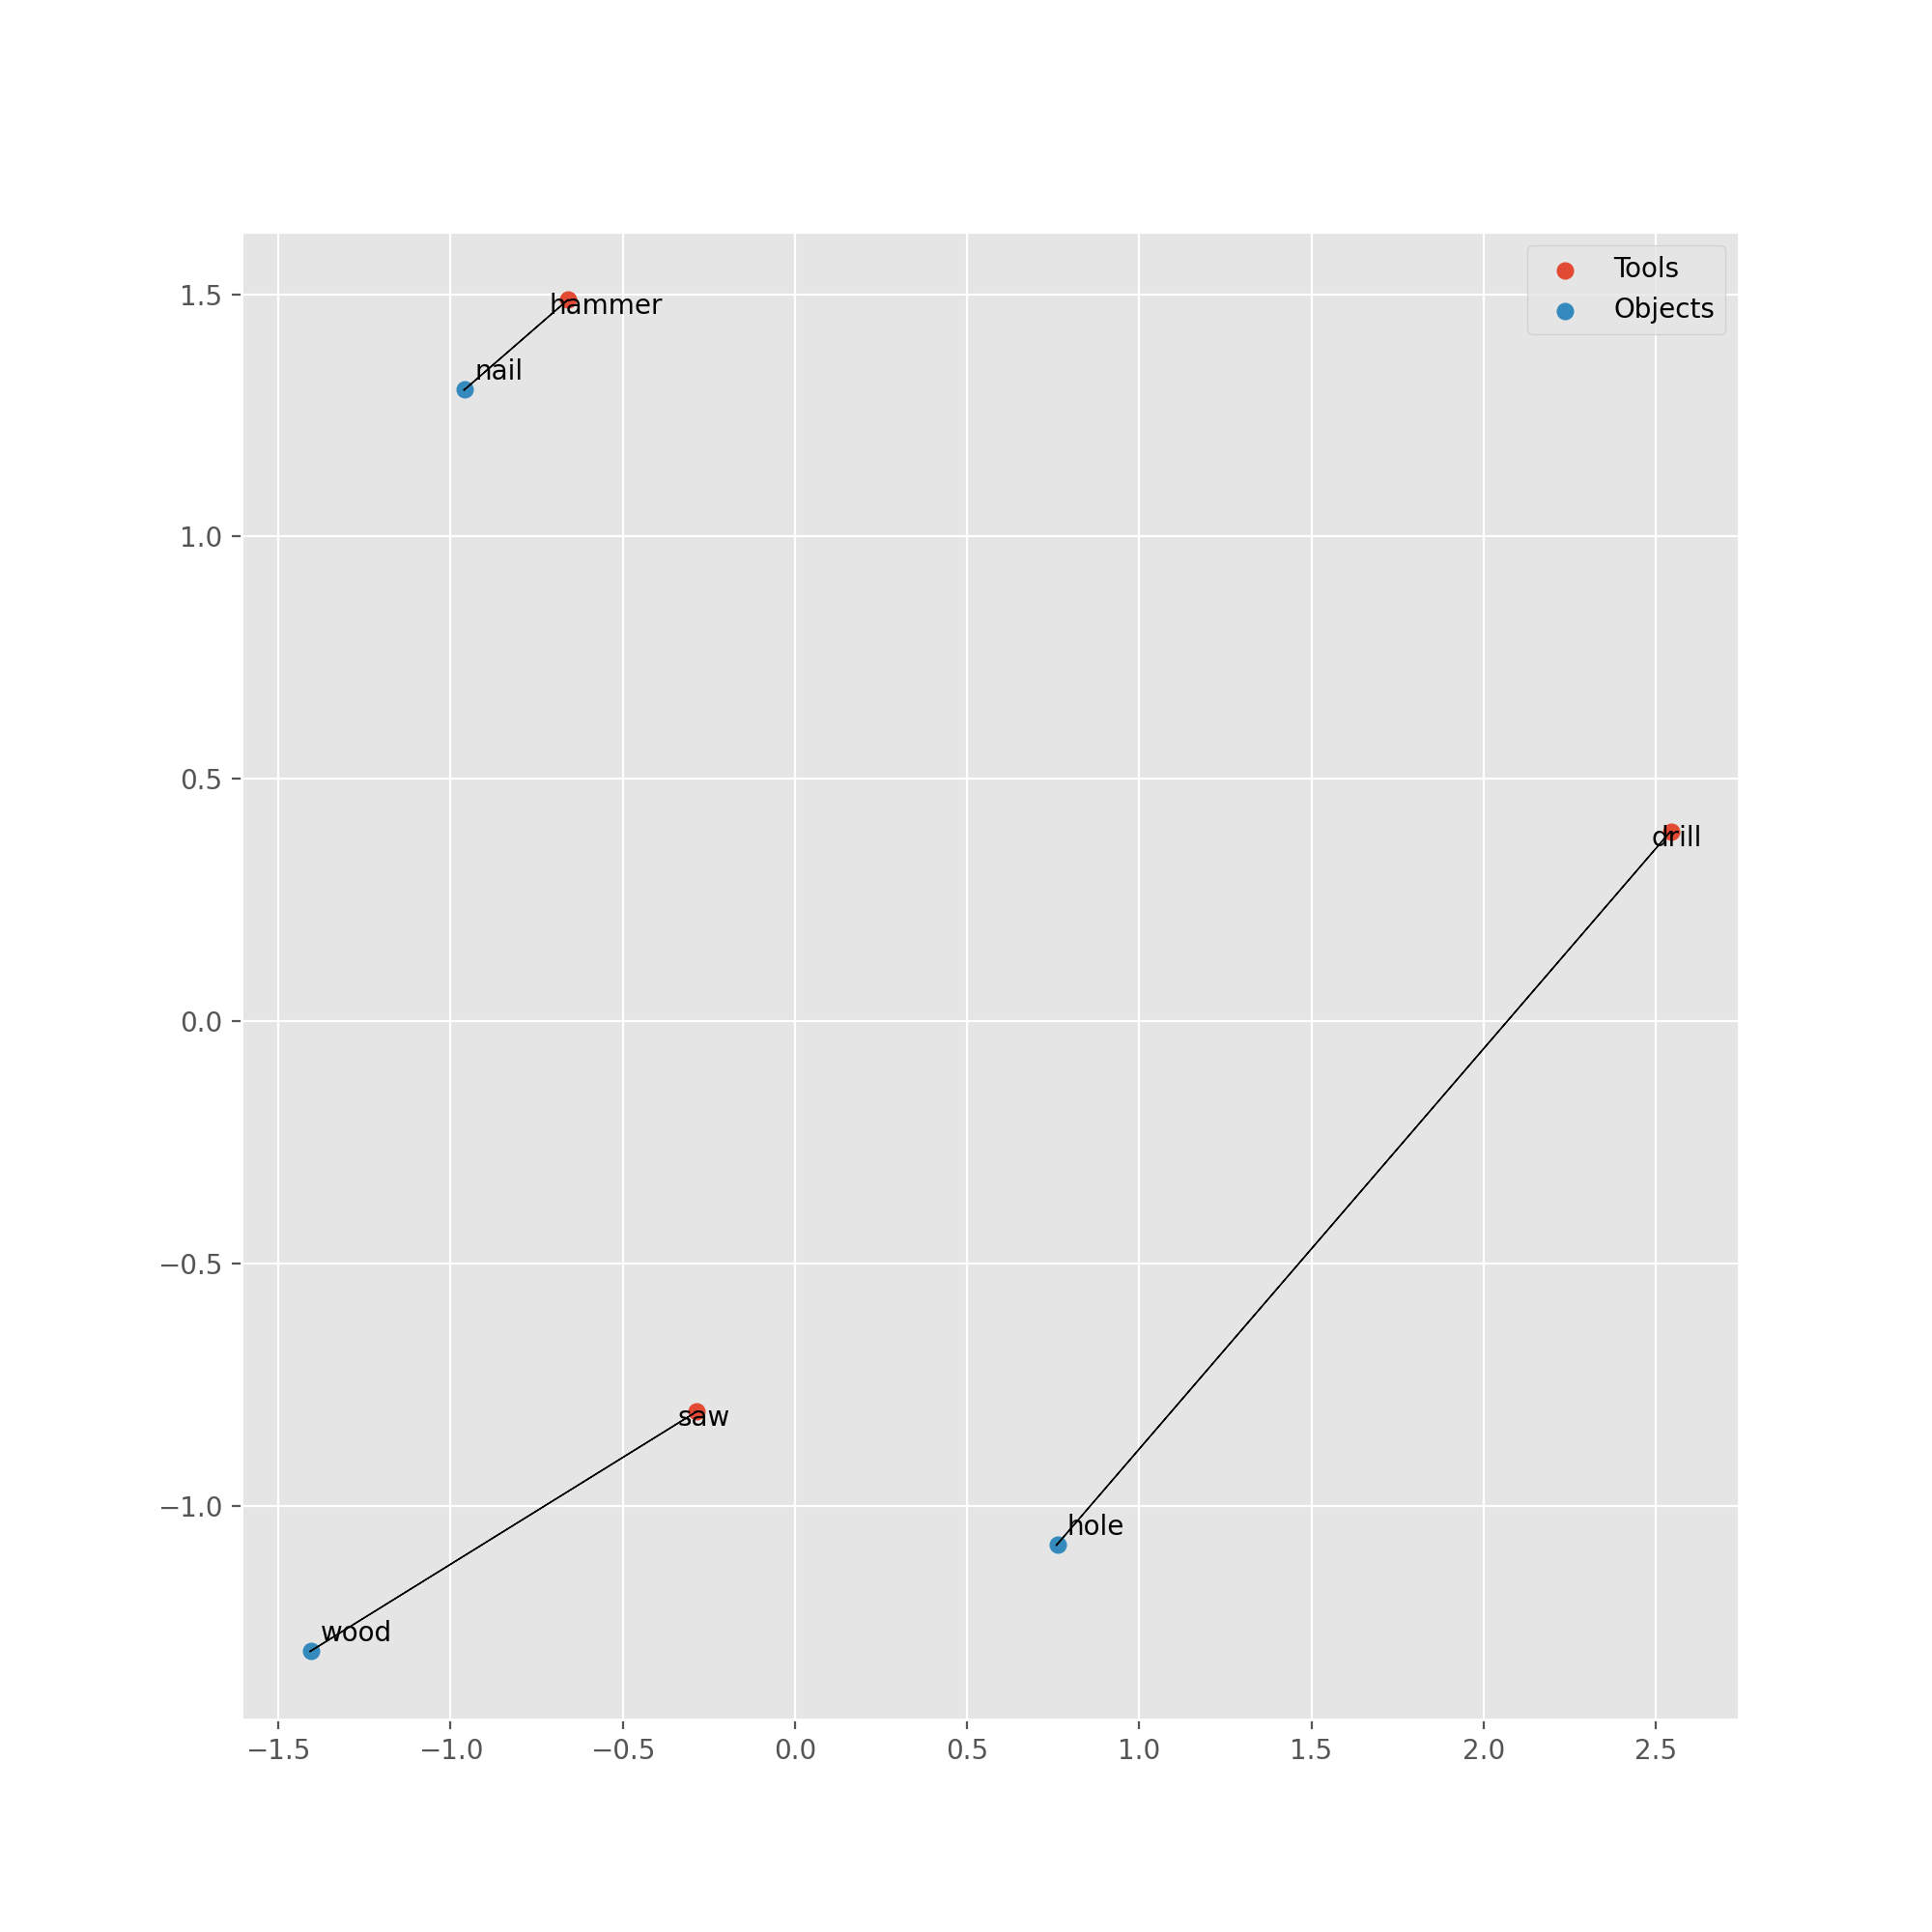

In [203]:
#plot animal food pairs
plot_pairs(model, tools, objects)

As we would expect, the pairs of analogies of tools and objects above are nearly parallel with one another.

## Train word-analogy and execute


Enter three words (EXIT to break): king man woman

Word: king  Position in vocabulary: 187

Word: man  Position in vocabulary: 243

Word: woman  Position in vocabulary: 1012

                                              Word              Distance
------------------------------------------------------------------------
                                              girl		0.542380
                                            loving		0.457864
                                          stranger		0.436738
                                              love		0.434233
                                             senex		0.418635
                                              maid		0.418048
                                              baby		0.415014
                                            bionic		0.412014

In [209]:
#compare model
most_similar = model.most_similar(positive=['king', 'woman'], negative=['man'])
print(most_similar)

[('queen', 0.7118191719055176), ('monarch', 0.6189674735069275), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321839332581), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.5181134343147278), ('sultan', 0.5098593831062317), ('monarchy', 0.5087412595748901)]


Enter three words (EXIT to break): paris france moscow

Word: paris  Position in vocabulary: 1055

Word: france  Position in vocabulary: 303

Word: moscow  Position in vocabulary: 2854

                                              Word              Distance
------------------------------------------------------------------------
                                            russia		0.692658
                                              ussr		0.551086
                                           finland		0.547139
                                          novgorod		0.510428
                                          abkhazia		0.508566
                                           russian		0.495257
                                          kalmykia		0.494455
                                            oblast		0.493113
                                        bolshevist		0.489863
                                         lithuania		0.486482
                                           germany		0.484993

In [210]:
#compare model
most_similar = model.most_similar(positive=['paris', 'moscow'], negative=['france'])
print(most_similar)

[('dubai', 0.4434893727302551), ('heidi', 0.44163426756858826), ('yesturday', 0.43807485699653625), ('christina', 0.43140000104904175), ('alexandra', 0.4258810579776764), ('hilton', 0.4227859079837799), ('lil_kim', 0.4222569167613983), ('zac_efron', 0.41654515266418457), ('natalie_portman', 0.41518905758857727), ('ktla', 0.4149516820907593)]


Enter three words (EXIT to break): madrid spain rome

Word: madrid  Position in vocabulary: 4733

Word: spain  Position in vocabulary: 804

Word: rome  Position in vocabulary: 938

                                              Word              Distance
------------------------------------------------------------------------
                                             dacia		0.553824
                                            legate		0.527551
                                        ostrogoths		0.526863
                                             italy		0.524671
                                              gaul		0.516169
                                           cilicia		0.508688
                                           albinus		0.507127
                                            greece		0.501251
                                         exarchate		0.493403


In [211]:
#compare model
most_similar = model.most_similar(positive=['madrid', 'rome'], negative=['spain'])
print(most_similar)

[('juve', 0.5551487803459167), ('juventus', 0.5504034161567688), ('real_madrid', 0.5476219058036804), ('barca', 0.5444825887680054), ("eto'o", 0.538358211517334), ('drogba', 0.5361745953559875), ('robinho', 0.5257367491722107), ('milan', 0.524126410484314), ('buffon', 0.523963451385498), ('ronaldo', 0.5238916873931885)]
